## SnappCloud RAG


In [4]:
pip install --quiet ollama sentence-transformers tqdm

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install --quiet langchain langchain_community chromadb unstructured markdown

Note: you may need to restart the kernel to use updated packages.


Ok, now lets do our RAG. Here we can use the cloud resources. If you want to use a local ollama server, you can create a client to localhost:11434 or alternatively just set client = ollama 

In [77]:
ollamaBase = 'http://ollama-alibo-gpu-testing.apps.private.okd4.teh-2.snappcloud.io/'
#ollamaBase = 'http://localhost:11434'
import ollama

def newOllamaClient(baseURL):
    return ollama.Client(baseURL)

client = newOllamaClient(baseURL=ollamaBase)

In [37]:
from langchain.document_loaders import DirectoryLoader
from langchain_community.document_loaders import UnstructuredMarkdownLoader
from langchain.text_splitter import SentenceTransformersTokenTextSplitter

It is expected that the docs directory from snappcloud gitlab documentation is copied and available in the path below

Now we fetch all available models on our local/remote GPU instance.

In [38]:
result = client.list()
print([x['name'] for x in result['models']])

['llama2:latest', 'nomic-embed-text:latest']


If you want to pull a specific model at this time, you can do it using the ollama api

In [39]:
embeddingModel = 'nomic-embed-text'
#embeddingModel = 'mxbai-embed-large'

try:
    client.show(embeddingModel)
except Exception as e:
    print('Model is not installed. Going to pull')
    client.pull(embeddingModel)

## Generate Emebddings

First we will see if the embeddings are already generated and persisted locally, in which case you can skip the rest of the activity

In [40]:
%%time
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import OllamaEmbeddings

embeddings = OllamaEmbeddings(model=embeddingModel,show_progress=True,base_url=ollamaBase)

vectorstore = Chroma('snappcloud',embeddings)
if vectorstore._collection.count() == 0:
    print("you need to follow the instructions in the next section and generate embeddings again")

print("vectorstore has {0} documents".format(vectorstore._collection.count()))

you need to follow the instructions in the next section and generate embeddings again
vectorstore has 0 documents
CPU times: user 5.3 ms, sys: 13.4 ms, total: 18.7 ms
Wall time: 60.1 ms


### Generate from scratch 

We will first checkout the git repo with markdown files

In [41]:
import os
if not os.path.exists('./user-docs'):
    !git clone https://gitlab.snapp.ir/snappcloud/user-docs
else:
    print("using existing repo")

using existing repo


In [42]:
loader = DirectoryLoader('./user-docs/docs',glob="**/*.md",loader_cls=UnstructuredMarkdownLoader)

In [43]:

docs = loader.load()
print(list(map(lambda x: x.metadata['source'], docs[0:10])))
print(len(docs))
#print(docs[10].page_content)

OllamaEmbeddings:   0%|                                                                                                                                                               | 0/473 [1:37:33<?, ?it/s]


['user-docs/docs/overview.md', 'user-docs/docs/support.md', 'user-docs/docs/terms.md', 'user-docs/docs/vpn-access.md', 'user-docs/docs/servicedesk.md', 'user-docs/docs/openstack/images.md', 'user-docs/docs/openstack/overview.md', 'user-docs/docs/openstack/networking.md', 'user-docs/docs/openstack/migrate-1g-to-10g.md', 'user-docs/docs/openstack/IaC.md']
127


Now we use our embedding model to create the embeddings and store them in chroma. If we are using the **mxbai-embed-large** model, whose **context window is 512**, so we must ensure all of our docs are of smaller size. On the other hand, nomic has a much bigger context window of 8k and doesn't need this. Actually it appears like *nomic-embed-text* is a much better model. The tokens_per_chunk parameter should be set based on the context window for embedding model. You can see the context window details using ollama show


In [48]:
print("using {0} \n{1}".format(embeddingModel,client.show(embeddingModel)['parameters']))

using nomic-embed-text 
num_ctx                        8192


In [22]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=384)
splits = token_splitter.split_documents(docs)
print(len(splits))

/Users/qasim/miniconda3/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


473


We should save the embeddings in a vector db, such as chroma or qdrant. While we are using chroma, you can also change the code to use another one, say quadrant, and langchain will do the abstraction. 

In [49]:
%%time

vectorstore = Chroma.from_documents(collection_name='snappcloud',documents=splits, embedding=embeddings,persist_directory='./chroma')

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 473/473 [00:51<00:00,  9.25it/s]


CPU times: user 3.37 s, sys: 718 ms, total: 4.09 s
Wall time: 51.5 s


Here we just make sure that the number of docs in collection matches the output of split

In [50]:
print(vectorstore._collection.count())
print(len(splits))

473
473


### Query
We can directly query the vectorstore. The quality of RAG is as good as the context provided to llm and no better, 
and this is one way to see the the context that is being passed.

In [51]:
query = "What are the external IPs for snappcloud that i need to whitelist?"
#print(token_splitter.count_tokens(query))
qembed = embeddings.embed_query(query)
results = vectorstore._collection.query(query_embeddings = qembed, n_results=5)
retrieved_documents = results['documents'][0]

for document in retrieved_documents:
    print(document)
    print('\n')

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.61it/s]


add network. snappcloud. io / address - pool : vpn - access label to assign your service an external - ip which is routable from vpn. for example : { ` apiversion : v1 kind : service metadata : labels : network. snappcloud. io / address - pool : vpn - access name : sample - svc - lb spec : type : loadbalancer selector : app : sample - lb ports : - name : web port : 8080 protocol : tcp targetport : 8080 allocateloadbalancernodeports : false ` } for vpn - accessible service type loadbalancer, the allocated ips are in the range 172. 16. 88. 0 / 22 for teh - 2 / afranet and 172. 21. 88. 0 / 22 for teh - 1 / asiatech which is accessible via vpn ( in your local system ). the vpn - accessible external - ips can be accessed from any vms and baremetals as well as vpn users, make sure your application is secure enough to be exposed. in this case, it is recommended to use l7 solutions or you can use spec. loadbalancersourceranges for whitelisting client ips explained in ip whitelisting section. a

In [54]:
retriever = vectorstore.as_retriever()

llmModel = 'llama3'
systemPrompt = """You are a helpful expert assistant. Your users are asking questions about snappcloud. You will be shown the user's question, and  relevant information from the documentation.
Answer the user's question using only this information and cite your sources"""

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

def ollama_llm(question, context):
    formatted_prompt = f"Question: {question}\n\nContext: {context}"
    response = client.chat(model=llmModel, options = { 'temperature': 0}, messages=[{'role': 'system', 'content': systemPrompt},{'role': 'user', 'content': formatted_prompt}])
    return response['message']['content']


In [55]:
# Define the RAG chain
def rag_chain(question):
    retrieved_docs = retriever.invoke(question)
    formatted_context = format_docs(retrieved_docs)
    print("using from context",list(map(lambda x: x.metadata['source'],retrieved_docs)))
    return ollama_llm(question, formatted_context)

In [58]:
%%time
result = rag_chain("What address should I use for jaeger agent on snappcloud?")
print(result)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.85it/s]


using from context ['user-docs/docs/observability/tracing.md', 'user-docs/docs/observability/tracing.md', 'user-docs/docs/observability/tracing.md', 'user-docs/docs/observability/tracing.md']
According to the documentation, you should use the following address for the Jaeger agent on SnappCloud:

"jaeger-collector.service.consul: 14250"

This is mentioned in the section "Jaeger Agent" under the heading "Tracing". The full quote is:

"If you want to use GRPC to expose traces on the Jaeger client, you should directly connect to the collector component on port 14250. So you can use this address: 'jaeger-collector.service.consul: 14250'".

Source: SnappCloud documentation, "Tracing" section, "Jaeger Agent" subsection.
CPU times: user 25.9 ms, sys: 23.9 ms, total: 49.8 ms
Wall time: 10.4 s


In [59]:
%%time
result = rag_chain("What are the external IPs for snappcloud that i need to whitelist?")
print(result)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.93it/s]


using from context ['user-docs/docs/networking/expose-tcp-applications.md', 'user-docs/docs/networking/expose-tcp-applications.md', 'user-docs/docs/databases/clickhouse.md', 'user-docs/docs/networking/expose-tcp-applications.md']
According to the documentation, the external IPs for SnappCloud that you need to whitelist are:

* For VPN-Accessible Service Type LoadBalancer:
	+ 172.16.88.0/22 (for Afranet)
	+ 172.21.88.0/22 (for Asiatech)

These IP ranges can be accessed via VPN and are routable from the VPN.

Additionally, if you need to access the load balancer from a non-cloud VM or baremetal in SnappCloud's Afranet datacenter with a 10G network, you will need to configure static network routes:

* To connect to teh-1: `ip route add 172.21.56.0/21 via 172.20.3.254`
* To connect to teh-2: `ip route add 172.16.56.0/21 via 172.20.3.254`

If your VM or baremetal cannot ping the 10G gateway (172.20.3.254), you will need to ask the DevOps team to set up access to the 10G network.

Please not

In [60]:
result = rag_chain("I need to increase the quota for my project, how can I do this?")
print(result)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.85it/s]

using from context ['user-docs/docs/management/quotas-and-limitations.md', 'user-docs/docs/servicedesk.md', 'user-docs/docs/management/quotas-and-limitations.md', 'user-docs/docs/servicedesk.md']


To increase the quota for your project, follow these steps:

1. Check if your project is already joined to a team by running the command `oc describe project <project_name>` or checking the console UI under "Projects" > "Project Details" > "YAML".
2. If your project is not joined to a team, you can join it to a team by adding the label `snappcloud.io/team` with the value of your team name.
3. To view the current team quota, run the command `oc describe appliedclusterresourcequota <team_name>` or check the console UI under "Administration" > "Resource Quotas" > "<team_name>" > "Details".
4. As an admin of each project, you can edit the project quota by running the command `oc edit quota -n <project_name>` or editing the project quota in the console UI under "Administration" > "Resource Quotas" > "Default" > "YAML".

To request a quota increase, follow these steps:

1. Go to the Cloud Service Desk page.
2. Click on "Increase OpenStack Quota" to create a new ticket.
3. Fill in the require

In [79]:
result = rag_chain("What IP addresses does snappcloud use for outgoing traffic?")
print(result)

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.50it/s]


using from context ['user-docs/docs/networking/ingress-routing/overview.md', 'user-docs/docs/networking/ingress-routing/overview.md', 'user-docs/docs/networking/expose-tcp-applications.md', 'user-docs/docs/networking/expose-tcp-applications.md']
According to the documentation, Snappcloud uses the following public IP addresses for outgoing traffic:

* teh-1: 178.216.250.136/30 (old ones were 178.22.121.34 and 178.22.121.35)
* teh-2: 86.104.35.16/29 (old one was 79.175.139.36)

Please note that there is a small chance that these IP addresses might change in the future, and this will be communicated to users.

Source:
https://snappcloud.com/docs/routing-overview
https://snappcloud.com/docs/accessing-loadbalancer-external-ips-from-non-cloud-vm-baremetal


## Visualization

In [76]:
import chromadb
dbclient = chromadb.PersistentClient(path='./chroma')
col = dbclient.get_collection('snappcloud')
print(col.count())

all_embeddings = col.get(include=['embeddings'])['embeddings']
print(len(all_embeddings))

473
473


In [68]:
pip install --quiet umap-learn matplotlib

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [63]:
import umap.umap_ as umap
import numpy as np
from tqdm import tqdm

reducer = umap.UMAP(random_state=0,transform_seed=0)
umap_transform = reducer.fit(all_embeddings)

/Users/qasim/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [64]:
def project_embeddings(embeddings, umap_transform):
    """project embeddings into a 2d space"""
    umap_embeddings = np.empty((len(embeddings),2))
    for i,embedding in enumerate(tqdm(embeddings)):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


In [65]:
projected_all_embeddings = project_embeddings(all_embeddings,umap_transform)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 473/473 [02:21<00:00,  3.34it/s]


(8.265359687805176, 16.55413646697998, 4.395151805877686, 12.469065952301026)

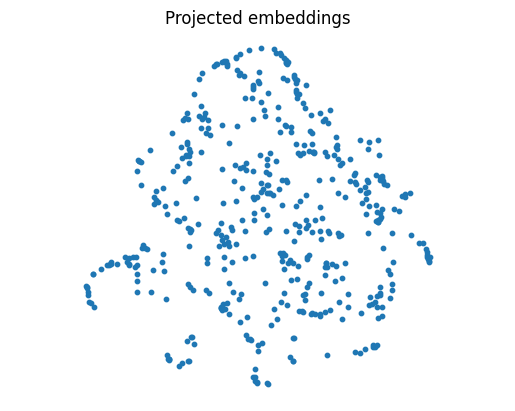

In [71]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_all_embeddings[:,0],projected_all_embeddings[:,1], s=10)

plt.gca().set_aspect('equal','datalim')
plt.title('Projected embeddings')
plt.axis('off')

All right, now let's rerun a query and see where it lands in the embedding space.

In [70]:
query = "What are the external IPs for snappcloud that i need to whitelist?"
#print(token_splitter.count_tokens(query))
query_embedding = embeddings.embed_query(query)
results = col.query(query_embeddings = qembed, n_results=5,include=['documents','embeddings'])
result_embeddings = results['embeddings'][0]

OllamaEmbeddings: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.23it/s]


In [73]:
projected_query_embeddings = project_embeddings([query_embedding],umap_transform)
projected_result_embeddings = project_embeddings(result_embeddings,umap_transform)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.93it/s]


(8.265359687805176, 16.55413646697998, 4.395151805877686, 12.469065952301026)

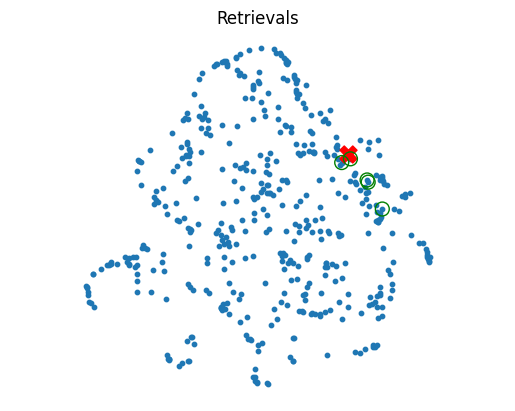

In [74]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_all_embeddings[:,0],projected_all_embeddings[:,1], s=10)
plt.scatter(projected_query_embeddings[:,0],projected_query_embeddings[:,1], s=150,marker='X', color='r')
plt.scatter(projected_result_embeddings[:,0],projected_result_embeddings[:,1], s=100, facecolors='none',edgecolors='g')

plt.gca().set_aspect('equal','datalim')
plt.title('Retrievals')
plt.axis('off')